In [3]:
path = "/content/drive/MyDrive/ColabNotebooks/PROGS/M_LSTM_AE"

%cd {path}

/content/drive/MyDrive/ColabNotebooks/PROGS/M_LSTM_AE


In [4]:
# Libs

import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model
import seaborn as sns

Start date is:  1999-01-04 00:00:00
End date is:  2023-10-24 00:00:00


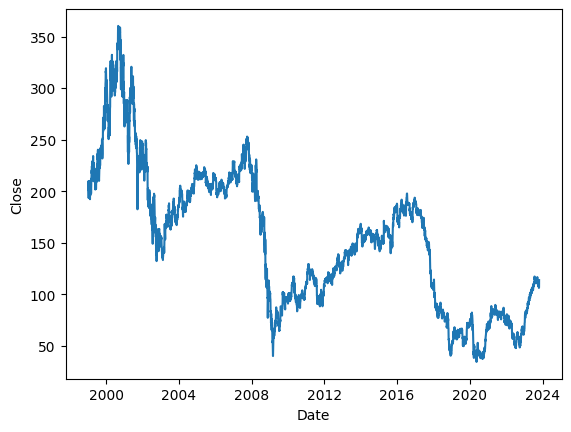

In [5]:
# Import data

dataframe = pd.read_csv('data/GE.csv')
df = dataframe[['Date', 'Close']].copy()
df['Date'] = pd.to_datetime(df['Date'])

sns.lineplot(x=df['Date'], y=df['Close'])

print("Start date is: ", df['Date'].min())
print("End date is: ", df['Date'].max())

In [6]:
# Adjust format

# float64 more prcise but takes more memory
# float32 less accurate but less ressource consumption

# to convert
# df['Close'] = df['Close'].astype('float32')

print(df.dtypes)

Date     datetime64[ns]
Close           float64
dtype: object


<Axes: xlabel='Date', ylabel='Close'>

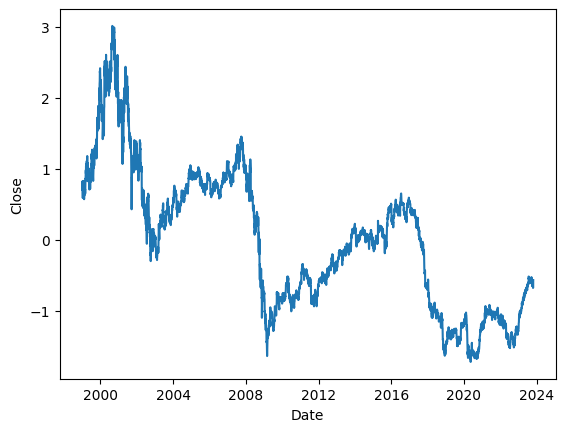

In [7]:
# Normalization

# Normalization is the process of scaling data to a common range to help machine learning models perform better.
# LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# possible normalizations:
#scaler = MinMaxScaler() // QuantileTransformer() // StandardScaler()

scaler = StandardScaler()
scaler = scaler.fit(df[['Close']])
df['Close'] = scaler.transform(df[['Close']])

sns.lineplot(x=df['Date'], y=df['Close'])

In [8]:
import array
from keras.src.callbacks import time
# Splitting and Sequencing

train, test = df.loc[df['Date'] <= '2016-12-31'], df.loc[df['Date'] > '2016-12-31']

seq_size = 30  # Number of time steps to look back

# The following function creates the Feature Input X and Target Y
# X would have multiple arrays of length seq_size, that slide by one value each time
# Y would have the value that would follow each array
# the goal is basically having X as the training set in each step and the next value Y as the target to be predicted based on the previous seq_size values

# Note: Larger sequences (look further back) may improve forecasting, but more consumption

def to_sequences(x, y, seq_size=1):
    x_values = []
    y_values = []

    for i in range(len(x)-seq_size):
        x_values.append(x.iloc[i:(i+seq_size)].values)
        y_values.append(y.iloc[i+seq_size])

    return np.array(x_values), np.array(y_values)

trainX, trainY = to_sequences(train[['Close']], train['Close'], seq_size) # x passed as a Dataframe, and y as a Series
testX, testY = to_sequences(test[['Close']], test['Close'], seq_size)

In [9]:
print(trainX.shape[1], trainX.shape[1], trainX.shape[2])

30 30 1


In [10]:
# Model 1

seq_size = trainX.shape[1]

model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(RepeatVector(trainX.shape[1]))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(trainX.shape[2])))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 repeat_vector (RepeatVecto  (None, 30, 64)            0         
 r)                                                              
                                                                 
 lstm_2 (LSTM)               (None, 30, 64)            33024     
                                                                 
 lstm_3 (LSTM)               (None, 30, 128)           98816     
                                                                 
 time_distributed (TimeDist  (None, 30, 1)             129       
 ributed)                                               

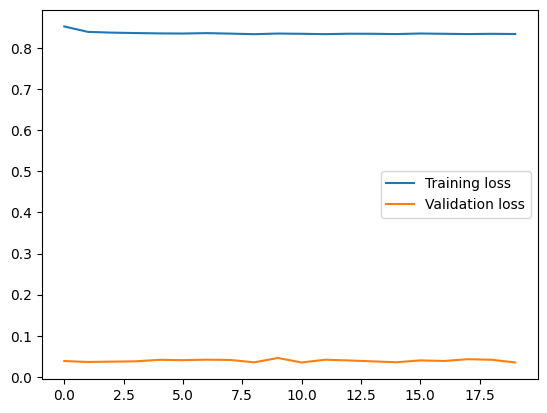

In [11]:
# Training

history = model.fit(trainX, trainY, epochs=20, batch_size=32, validation_split=0.1, verbose=0)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [12]:
# Evaluate

model.evaluate(testX, testY)

53/53 [==============================] - 2s 35ms/step - loss: 2.0681


2.068132162094116

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 repeat_vector_1 (RepeatVec  (None, 30, 128)           0         
 tor)                                                            
                                                                 
 lstm_5 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                                 
 time_distributed_1 (TimeDi  (None, 30, 1)             129       
 stributed)                                           

1.3644012212753296

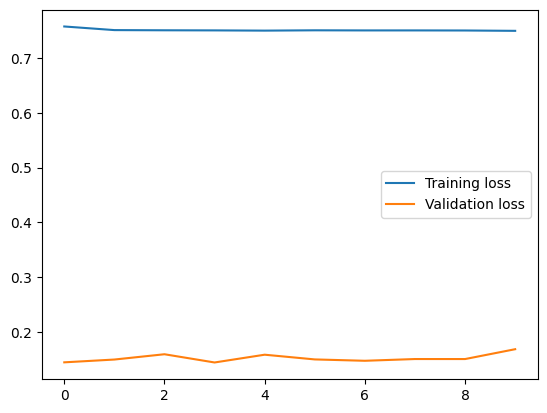

In [13]:
# Model 2
seq_size = trainX.shape[1]
model = Sequential()
model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(rate=0.2))

model.add(RepeatVector(trainX.shape[1]))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(trainX.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

# Training
history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_split=0.1, verbose=0)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

# Evaluate
model.evaluate(testX, testY)

### Anomaly Detection

141/141 [==============================] - 8s 54ms/step


(array([355., 350., 321., 340., 437., 448., 230., 206., 215.,  98., 129.,
        153., 153.,  72., 137., 280., 109.,  45.,  73.,  66.,  71.,  37.,
         56.,  46.,   8.,   9.,  10.,  11.,   9.,  25.]),
 array([0.02697111, 0.10151399, 0.17605688, 0.25059976, 0.32514265,
        0.39968553, 0.47422842, 0.54877131, 0.62331419, 0.69785708,
        0.77239996, 0.84694285, 0.92148573, 0.99602862, 1.07057151,
        1.14511439, 1.21965728, 1.29420016, 1.36874305, 1.44328593,
        1.51782882, 1.59237171, 1.66691459, 1.74145748, 1.81600036,
        1.89054325, 1.96508613, 2.03962902, 2.11417191, 2.18871479,
        2.26325768]),
 <BarContainer object of 30 artists>)

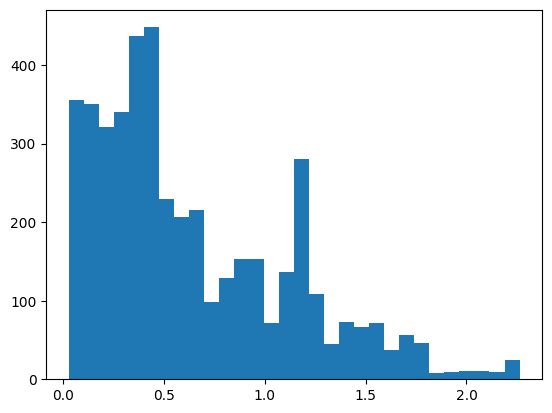

In [14]:
trainPredict = model.predict(trainX)
trainMAE = np.mean(np.abs(trainPredict - trainX), axis=1)
plt.hist(trainMAE, bins=30)

53/53 [==============================] - 4s 81ms/step


(array([ 66.,  11.,  27.,  11.,  11.,  11.,  15.,  27.,   5.,   5.,   4.,
          5.,   4.,   5.,  65.,  46.,  36.,  24.,  22.,  36., 163., 167.,
        163., 112., 105., 164., 125.,  65.,  58., 126.]),
 array([0.06392153, 0.12593572, 0.18794992, 0.24996412, 0.31197831,
        0.37399251, 0.43600671, 0.4980209 , 0.5600351 , 0.6220493 ,
        0.68406349, 0.74607769, 0.80809189, 0.87010608, 0.93212028,
        0.99413448, 1.05614868, 1.11816287, 1.18017707, 1.24219127,
        1.30420546, 1.36621966, 1.42823386, 1.49024805, 1.55226225,
        1.61427645, 1.67629064, 1.73830484, 1.80031904, 1.86233323,
        1.92434743]),
 <BarContainer object of 30 artists>)

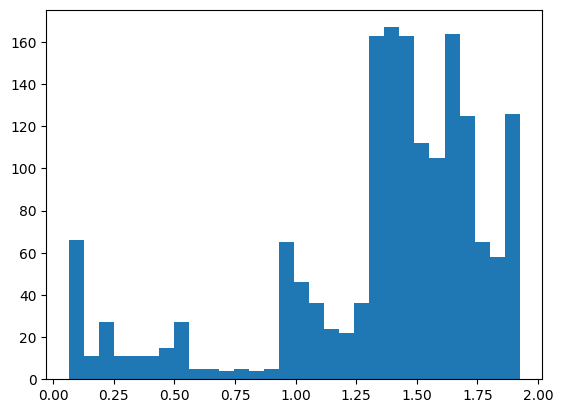

In [15]:
testPredict = model.predict(testX)
testMAE = np.mean(np.abs(testPredict - testX), axis=1)
plt.hist(testMAE, bins=30)

<Axes: xlabel='Date', ylabel='testMAE'>

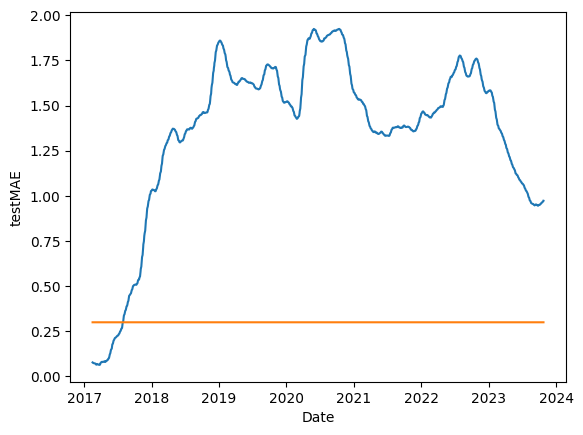

In [16]:
#Capture all details in a DataFrame for easy plotting
max_trainMAE = 0.3  #or Define 90% value of max as threshold.
anomaly_df = pd.DataFrame(test[seq_size:])
anomaly_df['testMAE'] = testMAE
anomaly_df['max_trainMAE'] = max_trainMAE
anomaly_df['anomaly'] = anomaly_df['testMAE'] > anomaly_df['max_trainMAE']
anomaly_df['Close'] = test[seq_size:]['Close']

#Plot testMAE vs max_trainMAE
sns.lineplot(x=anomaly_df['Date'], y=anomaly_df['testMAE'])
sns.lineplot(x=anomaly_df['Date'], y=anomaly_df['max_trainMAE'])

<Axes: >

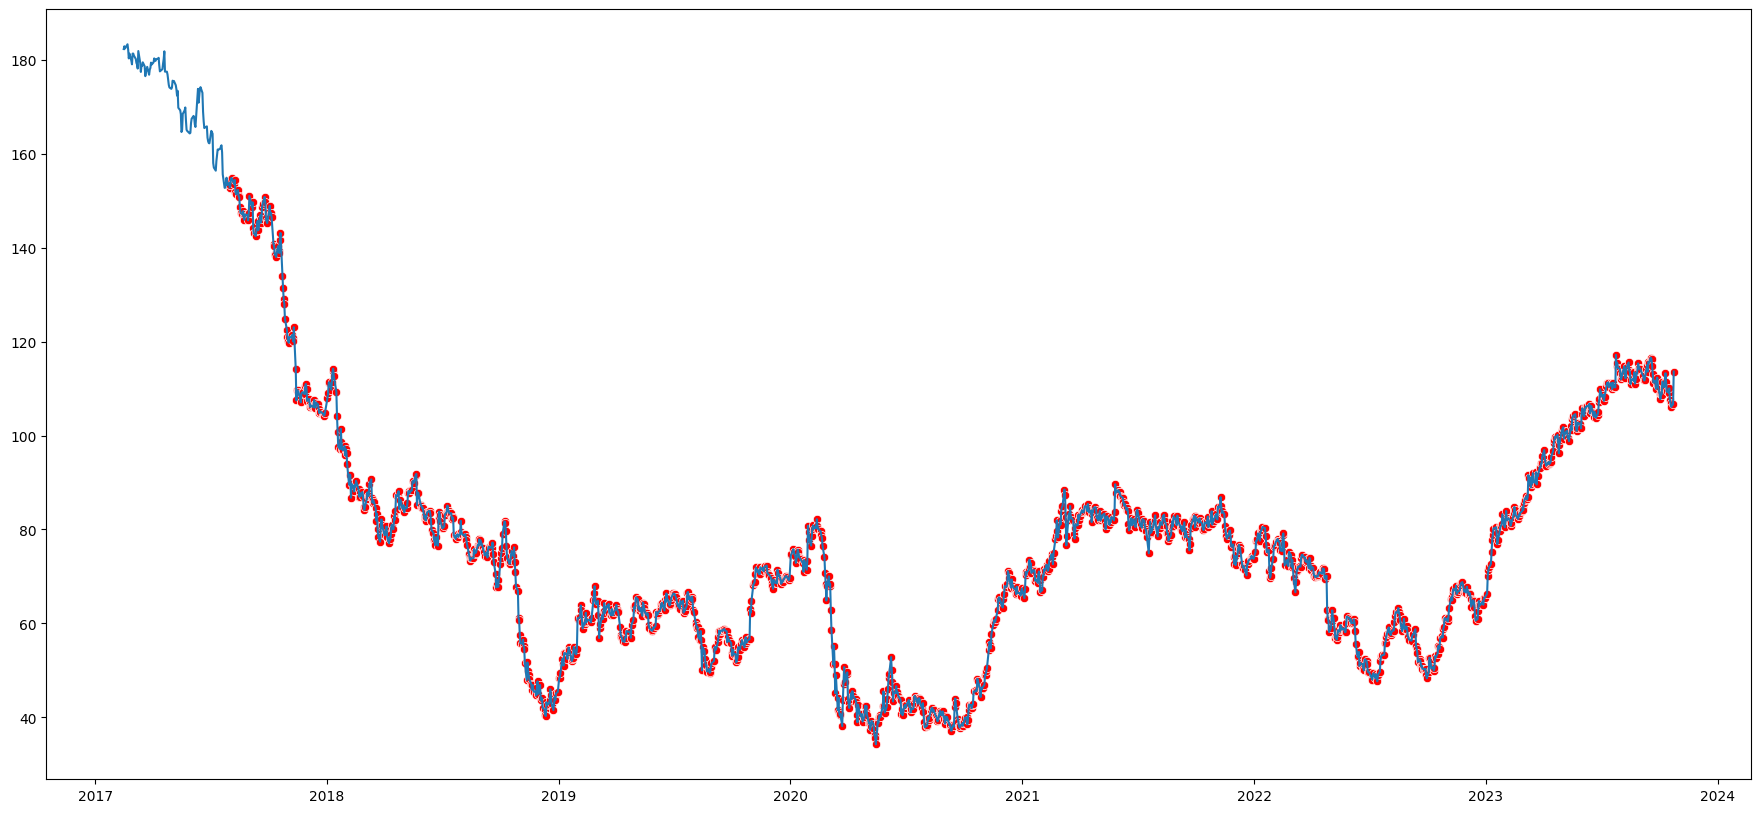

In [17]:
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]

#Plot anomalies
plt.figure(figsize=(22, 10))
sns.lineplot(x=anomaly_df['Date'].values, y=scaler.inverse_transform(anomaly_df['Close'].values.reshape(-1, 1)).flatten())
sns.scatterplot(x=anomalies['Date'].values, y=scaler.inverse_transform(anomalies['Close'].values.reshape(-1,1)).flatten(), color='r')